# Section 1 Example

Bennet Meyers
6/22/21

We construct a signal decomposition problem by summing Gaussian noise, a smooth signal (sum of sinusoids), and two-state (Boolean) signal. We then look to solve the associated Signal Decomposition (SD) optimization problem. 

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [20]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, Boolean, SparseFirstDiffConvex
from osd.signal_decomp_admm import make_estimate
from osd.polish import boolean_polish
from osd.utilities import progress

In [4]:
# matplotlib.use('MacOSX')
# sns.set_context('notebook')

In [5]:
# %matplotlib inline

# import matplotlib
# sns.set_context('paper')
# matplotlib.rcParams['axes.unicode_minus'] = False
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [6]:
# sns.set_context('paper')
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })


## Problem data generation

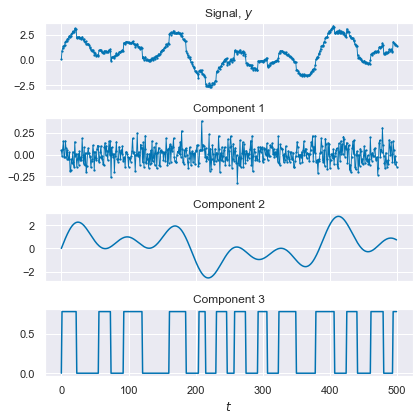

In [7]:
np.random.seed(42)

T = np.linspace(0, 1, 500)
scale = 0.7816 
rho = 0.75

x1_real = np.random.randn(len(T)) * 0.1

num_sines = 3
phases = np.random.uniform(low=0, high=2*np.pi, size=num_sines)
frequencies = np.random.uniform(low=1, high=5, size=num_sines)
params = zip(frequencies, phases)
x2_real = np.sum([np.sin(T * 2 * f * + ph) for f, ph in params], axis=0)

num_sines = 7
phases = np.random.uniform(low=0, high=2*np.pi, size=num_sines)
frequencies = np.random.uniform(low=30, high=32, size=num_sines)
params = zip(frequencies, phases)
x3_real = np.round(np.sign(np.sum([np.sin(T * 2 * f * + ph) for f, ph in params], axis=0)) / 2 + 0.5) * scale

X_real = np.array([x1_real, x2_real, x3_real])
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 6)) #(10, 8))
ax[0].plot(y, linewidth=0.9, marker='.', markersize=2.5)
ax[1].plot(x1_real, linewidth=0.9, marker='.', markersize=2.5)
ax[2].plot(x2_real)
ax[3].plot(x3_real)
ax[0].set_title('Signal, $y$')
for i in range(X_real.shape[0]):
    ax[i + 1].set_title('Component {}'.format(i + 1))
ax[-1].set_xlabel('$t$')
plt.tight_layout()
# fig = problem.plot_decomposition(X_real, figsize=(6, 6))
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/example-data.pgf')

## Decompose with known problem parameters

### Solve with ADMM

In [8]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=500)
c3 = Boolean(scale=scale)
components = [c1, c2, c3]
problem = Problem(y, components)

In [9]:
problem.decompose(admm=True, rho=rho, num_iter=100, stop_early=True)

[============================================================] 100.0% ...0.22 sec


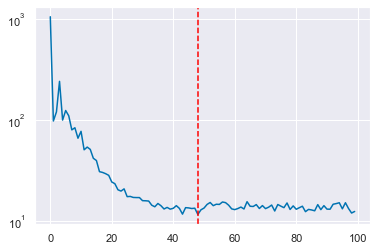

In [10]:
plt.plot(problem.admm_result['obj_vals'])
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')

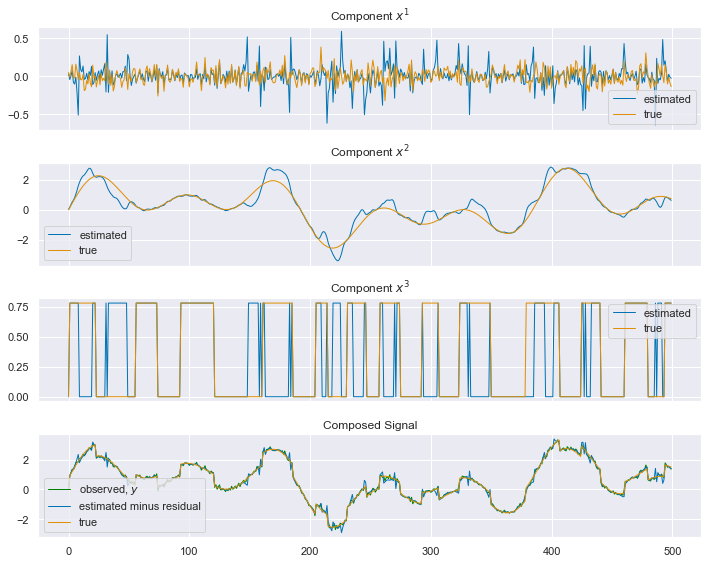

In [11]:
problem.plot_decomposition(X_real=X_real);

### Solve with CVXPY

In [12]:
problem.decompose(admm=False)

This problem is non-convex and not solvable with CVXPY. Please try solving with ADMM.


In [13]:
print([c.is_convex for c in problem.components])

[True, True, False]


## Weight optimization

Try optimizing for the weight on the smooth term only. Hold the scale term for the switching component at the known value.

In [14]:
ti = time()
num_samples = 10
thetas = np.logspace(-1, 6, 21)
out1 = pd.DataFrame(columns=['sample', 'theta', 'hmse'])
ix = 0
sample = np.arange(len(y))
total = num_samples * len(thetas)
for sn in range(num_samples):
    use_ix = np.random.choice(sample, size=int(0.8 * len(y)), replace=False)
    use_ix = np.array([True if s in use_ix else False for s in sample])
    for th in thetas:
        progress(ix, total, status='{}, {:.2f}          '.format(sn, th), bar_length=60)
        problem.components[1].set_weight(th)
        problem.decompose(admm=True, rho=rho, num_iter=100, use_set=use_ix, 
                          stop_early=True, verbose=False)
#         print(np.sum(problem.use_set))
        estimate0 = problem.estimates[0] + problem.estimates[1]
        estimate1 = problem.estimates[0] + problem.estimates[1] + problem.components[2].scale
        error0 = (y - estimate0)[~use_ix]
        error1 = (y - estimate1)[~use_ix]
        errors = np.array([error0, error1])
        choices = np.argmin(np.abs(errors), axis=0)
        M = np.array([choices == 0, choices == 1], dtype=int)
        error = np.diag(errors.T @ M)
        hmse = np.average(np.power(error, 2))
        out1.loc[ix] = [sn, th, hmse]
        ix += 1
progress(ix, total, status='done              \n', bar_length=60)
tf = time()
print('{:.2f} minutes'.format((tf - ti) / 60))

[============================================================] 100.0% ...done                  
0.37 minutes


In [15]:
summary = out1.groupby('theta').aggregate(np.average)
best_theta = summary.index[np.argmin(summary['hmse'])]
print('selected weight: {:.2f}'.format(best_theta))
summary.plot(y='hmse', figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.axvline(best_theta, color='red', ls='--', label='best theta')
plt.legend()
plt.title('Average holdout MSE over 10 random holdouts')
plt.show()

selected weight: 316.23


/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


## Weight and scale optimization

In [14]:
ti = time()
num_samples = 10
thetas = np.logspace(-1, 6, 21)
betas = np.linspace(0.1, 2, 21)
out2 = pd.DataFrame(columns=['sample', 'theta', 'beta', 'hmse'])
ix = 0
sample = np.arange(len(y))
total = num_samples * len(thetas) * len(betas)
# for sn in range(num_samples):
#     use_ix = np.random.choice(sample, size=int(0.8 * len(y)), replace=False)
#     use_ix = np.array([True if s in use_ix else False for s in sample])
#     for th in thetas:
#         for bt in betas:
#             progress(ix, total, status='{}, {:.2f}, {:.2f}          '.format(sn, th, bt), bar_length=60)
#             problem.components[1].set_weight(th)
#             problem.components[2].scale = bt
#             problem.decompose(admm=True, rho=rho, num_iter=100, use_set=use_ix, stop_early=True, verbose=False)
#             estimate0 = problem.estimates[0] + problem.estimates[1]
#             estimate1 = problem.estimates[0] + problem.estimates[1] + bt
#             error0 = (y - estimate0)[~use_ix]
#             error1 = (y - estimate1)[~use_ix]
#             errors = np.array([error0, error1])
#             choices = np.argmin(np.abs(errors), axis=0)
#             M = np.array([choices == 0, choices == 1], dtype=int)
#             error = np.diag(errors.T @ M)
#             hmse = np.average(np.power(error, 2))
#             out2.loc[ix] = [sn, th, bt, hmse]
#             ix += 1
# progress(ix, total, status='done              \n', bar_length=60)
out2 = pd.read_csv('section1_example_tuning.csv', index_col=0)
tf = time()
print('{:.2f} minutes'.format((tf - ti) / 60))

0.00 minutes


In [15]:
# out2.to_csv('section1_example_tuning.csv')

In [16]:
summary = out2.groupby(['theta', 'beta']).aggregate(np.average)
w, s = summary.iloc[np.argmin(summary['hmse'])].name
summary = summary['hmse'].unstack()
# summary.columns = np.round(summary.columns, 3)
# summary.index = np.round(summary.index, 0)
thetas = summary.index.values
betas = summary.columns.values

316.227766016838 0.765


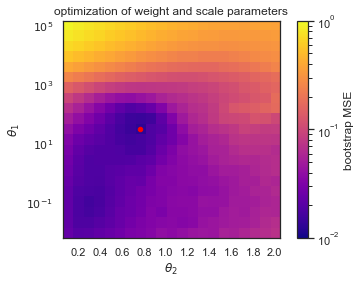

In [17]:
f2 = interp1d(betas, np.arange(len(betas)))
f3 = interp1d(thetas, np.arange(len(thetas)))
xticks = [f2(i).item() for i in np.linspace(0.2, 2, 10)]
yticks = [f3(i).item() for i in np.logspace(-1, 6, 8)[::2]]
xticklabels = np.round(np.linspace(0.2, 2, 10), 1)
yticklabels = np.array([
    '$10^{'+'{}'.format(i)+'}$' 
    for i in np.asarray(np.log10(np.logspace(-1, 6, 8)[::2]), dtype=int)
])[::-1]


# sns.heatmap((summary.iloc[::-1]), xticklabels=2, cmap='plasma', 
#             norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0),
#             cbar_kws={'label': 'bootstrap MSE'})

with sns.axes_style('white'):
    plt.imshow(summary.iloc[::-1].values, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0))
    plt.colorbar(label='bootstrap MSE')

ax = plt.gca()
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)
print(w, s)
sx = np.where(np.isclose(summary.columns, s))[0][0]
sy = np.where(np.isclose(np.round(summary.iloc[::-1].index), np.round(w)))[0][0]
plt.scatter(sx, sy, color='red', s=20)
plt.ylabel('$\\theta_1$')
plt.xlabel('$\\theta_2$')
plt.title('optimization of weight and scale parameters')
fig = plt.gcf()
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/example-parameter-tuning.pgf')

In [54]:
problem.estimates[[1, 2]]

(2, 500)

In [57]:
problem.components[1].set_weight(w)
problem.components[2].scale = s
problem.decompose(admm=True, rho=rho, num_iter=500, stop_early=True)

[============================================================] 100.0% ...0.97 sec


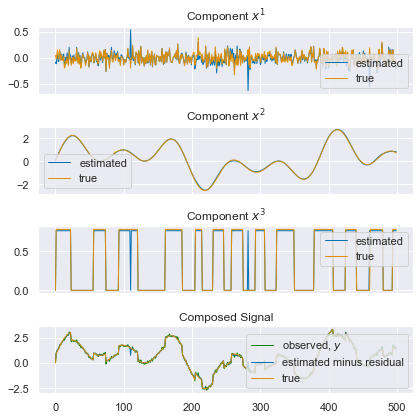

In [58]:
fig = problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/example-decomposition.pgf')

### Polishing

In [59]:
swapped_ix = boolean_polish(problem, 2, s)

In [60]:
swapped_ix

[110, 282, 460]

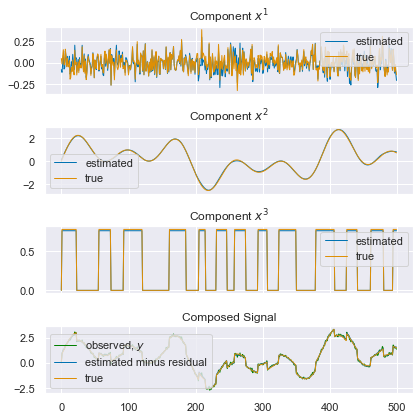

In [61]:
fig = problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/example-decomposition.pgf')

In [25]:
np.sqrt(np.average(np.power(problem.estimates[1] - x2_real, 2)))

0.040681782245019074

### Perform finer serach for scale parameter

In [18]:
## ti = time()
num_samples = 20
betas = np.linspace(s - 0.3, s + 0.3, 41)
out3 = pd.DataFrame(columns=['sample', 'beta', 'hmse'])
ix = 0
sample = np.arange(len(y))
total = num_samples * len(betas)
problem.components[1]._theta = w
for sn in range(num_samples):
    use_ix = np.random.choice(sample, size=int(0.8 * len(y)), replace=False)
    use_ix = np.array([True if s in use_ix else False for s in sample])
    for bt in betas:
        progress(ix, total, status='{}, {:.2f}          '.format(sn, bt), bar_length=60)
        problem.components[2].scale = bt
        problem.decompose(admm=True, rho=rho, num_iter=100, use_set=use_ix, stop_early=True, verbose=False)
        estimate0 = problem.estimates[0] + problem.estimates[1]
        estimate1 = problem.estimates[0] + problem.estimates[1] + bt
        error0 = (y - estimate0)[~use_ix]
        error1 = (y - estimate1)[~use_ix]
        errors = np.array([error0, error1])
        choices = np.argmin(np.abs(errors), axis=0)
        M = np.array([choices == 0, choices == 1], dtype=int)
        error = np.diag(errors.T @ M)
        hmse = np.average(np.power(error, 2))
        out3.loc[ix] = [sn, bt, hmse]
        ix += 1
progress(ix, total, status='done              \n', bar_length=60)
tf = time()
print('{:.2f} minutes'.format((tf - ti) / 60))

[============================================================] 100.0% ...done              
14.75 minutes


selected scale: 0.76


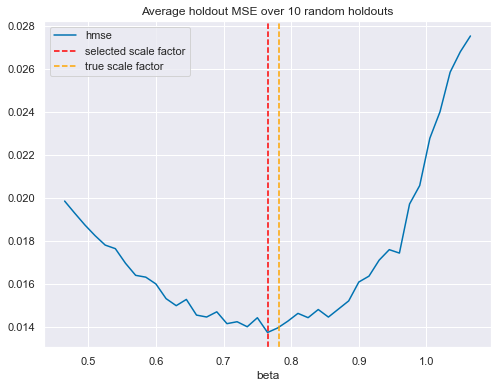

In [19]:
summary = out3.groupby('beta').aggregate(np.average)
best_beta = summary.index[np.argmin(summary['hmse'])]
print('selected scale: {:.2f}'.format(best_beta))
summary.plot(y='hmse', figsize=(8, 6))
# plt.xscale('log')
# plt.yscale('log')
plt.axvline(best_beta, color='red', ls='--', label='selected scale factor')
plt.axvline(scale, color='orange', ls='--', label='true scale factor')
plt.legend()
plt.title('Average holdout MSE over 10 random holdouts')
plt.show()

In [20]:
problem.components[1]._theta = w
problem.components[2].scale = best_beta
problem.decompose(admm=True, rho=rho, num_iter=500, stop_early=True)

[============================================================] 100.0% ...1.71 sec


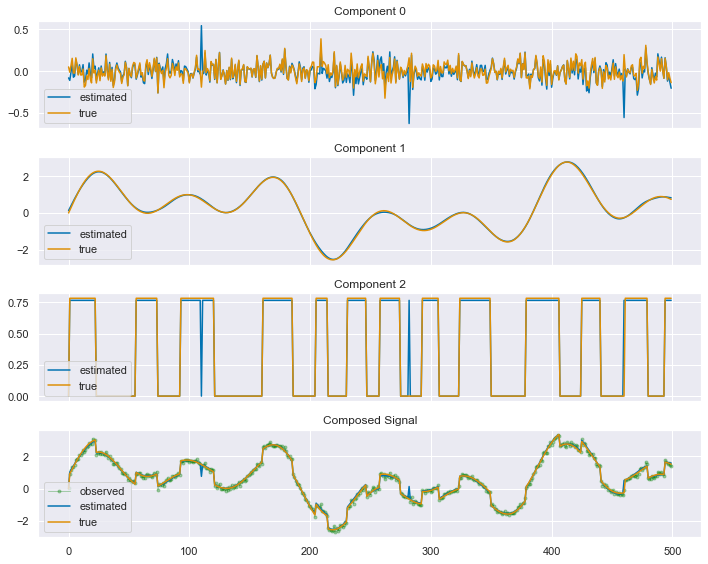

In [21]:
problem.plot_decomposition(X_real);

### Comparison to known scale factor

In [37]:
problem.components[1]._theta = best_theta
problem.components[2].scale = scale

In [38]:
problem.decompose(admm=True, rho=rho, num_iter=500, stop_early=True)

[============================================================] 100.0% ...1.25 sec


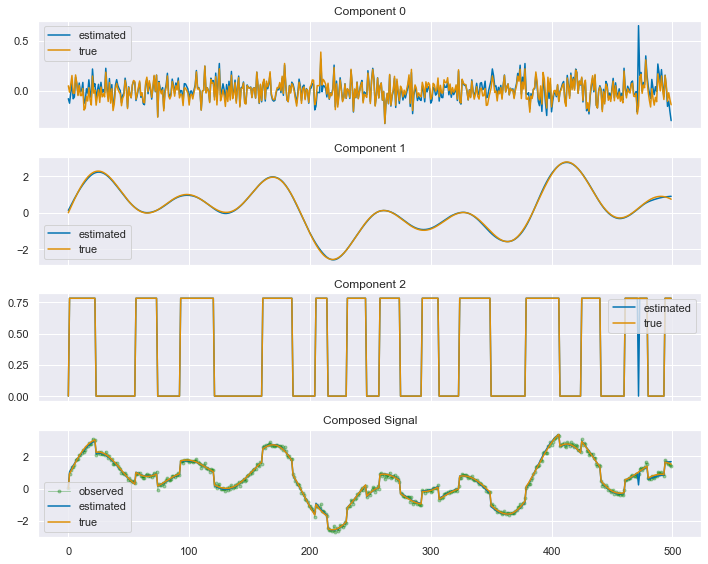

In [39]:
problem.plot_decomposition(X_real);

## $\ell_1$-penalized formulation

Just for a comparison, what if you modeled the third component as $\ell_1$-sparse first order differences?

### Solve with ADMM

In [25]:
c1_cvx = GaussNoise()
c2_cvx = SmoothSecondDifference(theta=1e2)
c3_cvx = SparseFirstDiffConvex(theta=1e0)
components_cvx = [c1_cvx, c2_cvx, c3_cvx]
problem_cvx = Problem(y, components_cvx)

In [26]:
problem_cvx.decompose(admm=True, rho=rho, num_iter=100)

[============================================================] 100.0% ...10.20 sec


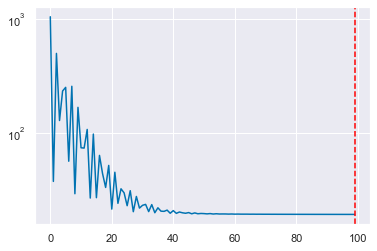

In [27]:
plt.plot(problem_cvx.admm_result['obj_vals'])
plt.axvline(problem_cvx.admm_result['it'], color='red', ls='--')
plt.yscale('log')

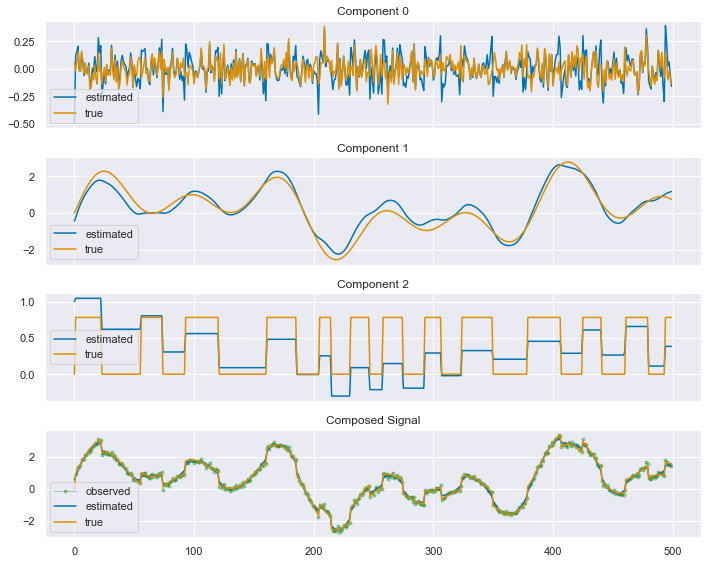

In [28]:
problem_cvx.plot_decomposition(X_real);

### Solve with CVXPY

In [29]:
problem_cvx.weights.value = [c.theta for c in problem_cvx.components]
problem_cvx.decompose(admm=False, solver='MOSEK')

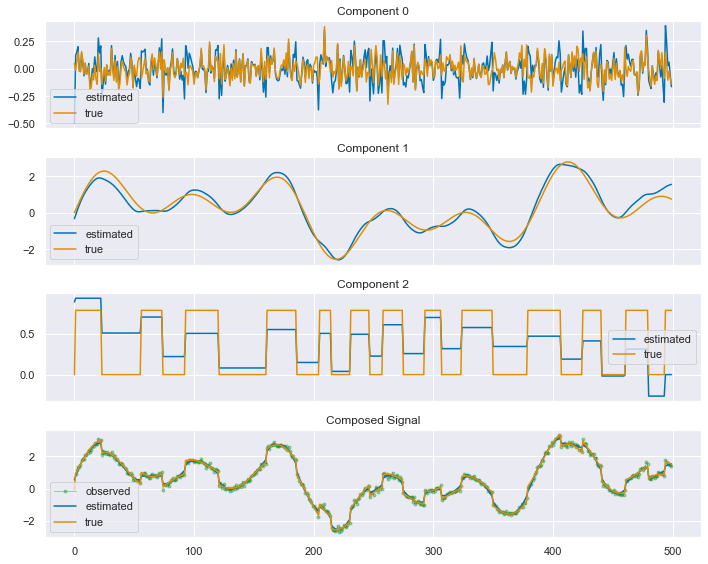

In [30]:
problem_cvx.plot_decomposition(X_real);